# Training of the multiclass classification model
## Author: Vilem Gottwald


#### Extract features and load GT classes from dataset

In [1]:
# import paths and 
from common import DATA_PATH, SCALER_PATH, DATASET_PATH, FEATURES_PATH, CLASSES_PATH
from classifier import FeaturesExtractor
import numpy as np

# Load features and gt classes
dataset_extractor = FeaturesExtractor()
try:
    dataset_extractor.load_from_saved_gt(FEATURES_PATH, CLASSES_PATH)
except FileNotFoundError:
    dataset_extractor.extract_from_dataset_gt(DATASET_PATH)
    dataset_extractor.save_gt(FEATURES_PATH, CLASSES_PATH)

objects_features, objects_classes = dataset_extractor.get_gt()

print('Shape of the extracted features:', objects_features.shape)
print('Shape of the GT classes:', objects_classes.shape)

# Check for NaN values in the extracted features
if np.isnan(objects_features).any():
    raise ValueError("NaN values in features")


Shape of the extracted features: (48104, 7, 37)
Shape of the GT classes: (48104,)


### Functions for finding the best dataset split

In [2]:
def split_data(data, offset, test_ratio=0.2):
    """ Split data into training and validation sets with given offset

    :param data: data to split
    :param offset: offset of the first sample in the data
    :param test_ratio: ratio of test data
    
    :return: tuple of training and validation data
    """
    test_samples_cnt = int(data.shape[0] * test_ratio)

    # sequence starting ar offset us used as test data
    test_data = data[offset : offset + test_samples_cnt]

    # train data - concatenate data before and after test data
    train_data = np.concatenate(
        (data[:offset], data[offset + test_samples_cnt :]), axis=0
    )
    return train_data, test_data


def classes_ratio(classes, percentage=True, ref_classes=None):
    """ Compute ratio of classes in the given data

    :param classes: classes to compute ratio from
    :param percentage: whether to return ratio as percentage
    
    :return: array of ratios
    """
    curr_class_ids, counts = np.unique(classes, return_counts=True)

    if ref_classes is not None and not curr_class_ids.shape[0] == len(ref_classes):
        # add missing classes counts
        for idx, ref_cls in enumerate(ref_classes):
            if ref_cls not in curr_class_ids:
                curr_class_ids = np.insert(curr_class_ids, idx, ref_cls)
                counts = np.insert(counts, ref_cls, 0)   

    if percentage:
        counts = counts / np.sum(counts)
    return counts


def classes_distribution_difference(ratio1, ratio2):
    """ Compute difference between two classes distributions

    :param ratio1: first distribution
    :param ratio2: second distribution

    :return: difference between distributions
    """

    return np.sum(np.abs(ratio1 - ratio2))


def find_min_difference_offset(classes, test_ratio=0.2):
    """ Find offset with smallest difference between training and validation classes distribution
    
    :param classes: classes to split
    :param test_ratio: ratio of test data

    :return: offset with smallest difference between training and validation classes distribution
    """
    ref_classes = np.unique(classes)

    differences = []
    for offset in range(classes.shape[0]):
        train_classes, test_classes = split_data(classes, offset)
        train_ratio = classes_ratio(train_classes, ref_classes=ref_classes)
        test_ratio = classes_ratio(test_classes, ref_classes=ref_classes)
        differences.append(classes_distribution_difference(train_ratio, test_ratio))

    # get index of offset with smallest percentage difference
        min_index = np.argmin(differences)
    return min_index, differences[min_index]

### Split dataset to train and test data
Different methods are contained in the following cell:
1. Shuffle split results in training with samples from the test data, because of the point clouds grouping over consecutive frames. 
2. First split has uneven distribution of classes in the train and test dataset.
3. Best split uses the functions defined in the previous cell, to find a testing sequence with the most similar class distributions

In [3]:
from sklearn.model_selection import train_test_split
X = objects_features.copy()
y = objects_classes.copy()

DATASET_TYPE = 'best_split'

if DATASET_TYPE == 'shuffle_split':
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
    
elif DATASET_TYPE == 'first_split':
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

elif DATASET_TYPE == 'best_split':
    min_index, min_difference = find_min_difference_offset(y)
    X_train, X_test = split_data(X, min_index)
    y_train, y_test = split_data(y, min_index)

train_ratio = classes_ratio(y_train) * 100
test_ratio = classes_ratio(y_test) * 100


train_strings = [f"{ratio:.2f} %" for ratio in train_ratio]
test_strings = [f"{ratio:.2f} %" for ratio in test_ratio]

print("Split index:", min_index)

print( "Classes:               noise       car        van    box truck    truck")
print("Train distribution:", *train_strings, sep='    ')
print("Test distribution: ", *test_strings, sep='    ')

Split index: 28162
Classes:               noise       car        van    box truck    truck
Train distribution:    4.38 %    49.96 %    14.75 %    7.35 %    23.57 %
Test distribution:     6.21 %    49.98 %    14.59 %    7.55 %    21.67 %


### Get class weights to overcome class imbalances

In [4]:
from sklearn.utils.class_weight import compute_class_weight

if len(y_train.shape) == 1:
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 4.562418494368702, 1: 0.4003537061118336, 2: 1.3562643171806168, 3: 2.7216407355021217, 4: 0.8486933509758519}


 ### Encode class labels in one hot encoding for training

In [5]:
from tensorflow import keras
from keras.utils import np_utils

print('Original class of the first object: ', y_train[0], y_test[0])

if len(y_train.shape) == 1:
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

print('Encoded class of the first object: ', y_train[0], y_test[0])

Original class of the first object:  4 4
Encoded class of the first object:  [0. 0. 0. 0. 1.] [0. 0. 0. 0. 1.]


### Normalization of features 

In [6]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Create scaler and save it for later use
scaler = MinMaxScaler()
scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
joblib.dump(scaler, SCALER_PATH)

print('Original features from the first time step of the first object\n', X_train[0][0])

# normalize training data
X_train = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print('\nNormalized  features from the first time step of the first object\n', X_train[0][0])


Original features from the first time step of the first object
 [  5.61487818   6.82223797   6.14307745   1.20735979   0.41247637
   0.17013675   9.77830124  12.10122967  11.10685811   2.32292843
   0.72850723   0.53072278   0.67462593   1.74327934   1.20779838
   1.0686534    0.36656      0.13436624  99.         134.
 116.92307692  35.           9.8485574   96.99408284 546.
 578.         563.53846154  32.           9.50801593  90.40236686
  16.53354454  17.57637405  17.13629679   1.04282951   0.32601906
   0.10628843  13.        ]

Normalized  features from the first time step of the first object
 [0.78179024 0.84101482 0.8080033  0.17195739 0.16469037 0.02712292
 0.12268508 0.15177109 0.13934045 0.06707996 0.05329159 0.00283999
 0.11275506 0.29056496 0.20186799 0.17913229 0.13294529 0.01767445
 0.5        0.38616715 0.49760729 0.14056225 0.15755525 0.02482366
 0.90848586 0.83646889 0.92839944 0.20253165 0.22864965 0.05228066
 0.69882273 0.70122374 0.69938437 0.05176798 0.04984958 0.0

### Train the model or load it if it was already trained

In [7]:
from tensorflow import keras
from keras.layers import LSTM, Dense, Masking
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.callbacks import TensorBoard


# Directory to save the model
MODEL_DIR = DATA_PATH / "training" / "models" / "multiclass"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

LOG_DIR = str(MODEL_DIR / "logs")
MODEL_PATH = str(MODEL_DIR / "model.h5")

# Load the model if it exists
try:
    model = keras.models.load_model(MODEL_PATH)

except OSError:

    # Model parameters
    TIMESTEPS_CNT = objects_features.shape[1]
    FEATURES_CNT = objects_features.shape[2]
    EPOCHS = 150
    CELLS = 10
    BATCH_SIZE = 256


    # Create the model
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(TIMESTEPS_CNT, FEATURES_CNT)))
    model.add(LSTM(CELLS, recurrent_dropout=0.2))
    model.add(Dense(5, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer="Adam",
        metrics=["categorical_accuracy", Precision(), Recall()],
    )

    model.summary()


    # Train the model
    model.fit(
        X_train,
        y_train,
        epochs=140,
        batch_size=256,
        class_weight=class_weights,
        validation_data=(X_test, y_test),
        callbacks=TensorBoard(log_dir=LOG_DIR, histogram_freq=1),
    )

    # Save the trained model
    model.save(MODEL_PATH)

### Functions for model evaluation

In [8]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt

def print_metrics(truth, prediction):
    """ Print accuracy, precision, recall, F1-score and confusion matrix.
    
    :param truth: ground truth labels
    :param prediction: predicted labels
    
    :return: confusion matrix
    """
    confusion_mtx = confusion_matrix(truth, prediction)

    print(f"Accuracy:  {accuracy_score(truth, prediction) * 100:0.2f} %")
    print(f"Precision: {precision_score(truth, prediction, average='macro') * 100:0.2f} %")
    print(f"Recall:    {recall_score(truth, prediction, average='macro') * 100:0.2f} %")
    print(f"F1-score:  {f1_score(truth, prediction, average='macro') * 100:0.2f} %")
    print(f"\nConfusion matrix:\n", confusion_mtx)

    return confusion_mtx



def plot_confusion_matrix(cm, save_path=None, labels=['noise', 'car', 'van', 'box truck', 'truck']):
    """ Plot confusion matrix.
    
    :param cm: confusion matrix
    :param save_path: path to save the plot
    :param labels: list of labels
    
    :return: None
    """

    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    ax = sn.heatmap(df_cm, cmap='Greens', annot=True, fmt='d')

    # Put x-axis ticks and labels on the top of the plot
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # Set axes labels
    ax.set_xlabel('Predicted', fontsize=13, weight='semibold', color='black')
    ax.set_ylabel('Ground truth', fontsize=13, weight='semibold')

    # Add space between labels and ticks
    ax.xaxis.set_label_coords(0.5, 1.1)
    ax.yaxis.set_label_coords(-0.1, 0.5)

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()


### Predict labels of test data and evaluate

Accuracy:  69.91 %
Precision: 60.78 %
Recall:    67.57 %
F1-score:  62.99 %

Confusion matrix:
 [[ 390  114   20   35   38]
 [ 325 3343  875   79  186]
 [ 108  248  894  115   39]
 [  35   12   97  431  151]
 [  65   23   56  274 1667]]


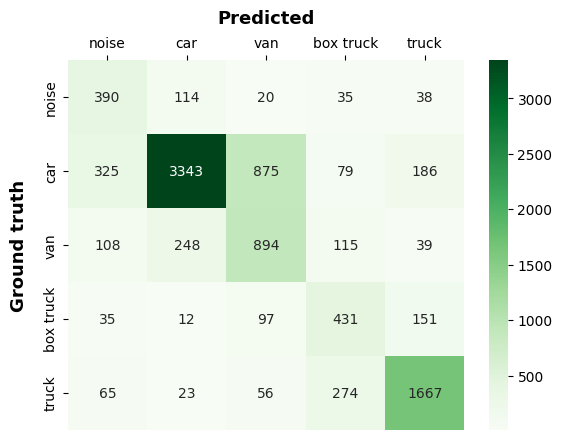

In [9]:
prediction_probabilities = model.predict(X_test)
prediction = np.argmax(prediction_probabilities, axis=1)
truth = np.argmax(y_test, axis=1)


cm = print_metrics(truth, prediction)
plot_confusion_matrix(cm, save_path=str(MODEL_DIR / "confusion_matrix.pdf"))
